In [1]:
import time
import copy
import random
import numpy as np
import distance
import math
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import optim

from IPython.display import Audio, display
def allDone():
    urL = 'http://www.wavsource.com/snds_2020-03-30_7102365145747638/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
# allDone()

random.seed(666)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
#### TRYING ALL MOTIFS !!! ####

# all_motifs = np.genfromtxt('data__for_nerds/all_motifs.csv',dtype='U')
# all_fams = np.genfromtxt('data__for_nerds/all_fams.csv',dtype='U')
# all_motifxFamMatrix = np.genfromtxt('data__for_nerds/all_motifxFamMatrix.csv',delimiter=',',dtype=int)

# test_motifs = np.genfromtxt('data__for_nerds/new_test_motifs.csv',dtype='U')

# test_idc = [np.where(all_motifs==x)[0][0] for x in test_motifs]
# train_idc = [i for i in range(len(all_motifs)) if i not in test_idc]

# train_motifs = all_motifs[train_idc]
# train_motifxFamMatrix = all_motifxFamMatrix[train_idc]
# test_motifs = all_motifs[test_idc]
# test_motifxFamMatrix = all_motifxFamMatrix[test_idc]

# fams = all_fams

In [3]:
train_motifs = np.genfromtxt('data__for_nerds/train_motifs.csv',dtype='U')
train_motifxFamMatrix = np.genfromtxt('data__for_nerds/train_motifxFamMatrix.csv',delimiter=',',dtype=int)
test_motifs = np.genfromtxt('data__for_nerds/new_test_motifs.csv',dtype='U')
test_motifxFamMatrix = np.genfromtxt('data__for_nerds/new_test_motifxFamMatrix.csv',delimiter=',',dtype=int)

fams = np.genfromtxt('data__for_nerds/fams.csv',dtype='U')

In [4]:
all_motifs = np.hstack([train_motifs,test_motifs])
all_motifxFamMatrix = np.vstack([train_motifxFamMatrix,test_motifxFamMatrix])

In [5]:
X_train, X_val = train_test_split(range(len(train_motifs)), test_size=0.1, random_state=666)
print(len(X_train), len(X_val))

5132 1283


In [6]:
AMINOS = 'XWGSAELQDMPFTRIHVNCY_K'

def get_oneHot_motifs(motifs, AMINOS=AMINOS):
    oneHot_motifs = []
    for motif in motifs:
        one_hotted = np.zeros((len(motif), len(AMINOS)),dtype=float)
        for i,aa in enumerate(motif):
            hot = AMINOS.find(aa)
            one_hotted[i][hot] = 1
        oneHot_motifs.append(one_hotted)
    oneHot_motifs = np.asarray(oneHot_motifs)
    oneHot_motifs = np.swapaxes(oneHot_motifs,1,2)
    return oneHot_motifs

In [7]:
train_oneHot_motifs = get_oneHot_motifs(train_motifs)
test_oneHot_motifs = get_oneHot_motifs(test_motifs)
all_oneHot_motifs = np.vstack([train_oneHot_motifs,test_oneHot_motifs])

print(train_oneHot_motifs.shape, test_oneHot_motifs.shape, all_oneHot_motifs.shape)

(6415, 22, 15) (1179, 22, 15) (7594, 22, 15)


In [8]:
def get_random_motif_and_fam(idc):
    mIdx = random.choice(idc)  
    motif = train_oneHot_motifs[mIdx] 
    fIdx = np.where(train_motifxFamMatrix[mIdx]==1)
    theseFams = fams[fIdx]
    return (mIdx,motif,fIdx,theseFams)

def get_batch(idc,batch_size):
    
    batch = []
    switch = 0
    
    while switch < batch_size:
        mIdx_1, motif_1, fIdx_1, fams_1 = get_random_motif_and_fam(idc)
        mIdx_2, motif_2, fIdx_2, fams_2 = get_random_motif_and_fam(idc)
        
        if len(fams_1)==0 and len(fams_2)==0: 
            continue
        
        label = distance.jaccard(set(fams_1),set(fams_2))
        if switch%2 != round(label): #   math.ceil(label): 
            continue
        switch += 1
            
        triplet = [motif_1, motif_2, label]
        batch.append(triplet)

    return batch

In [9]:
from scipy.spatial import distance
class SiameseLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, z1, z2, label, margin=2.0):
        euclidean_distance = F.pairwise_distance(z1, z2)
        manhattan_distance = torch.sum( torch.abs(z1-z2), axis=1)
        siam_loss = torch.mean((1-label) * torch.pow(manhattan_distance, 2) +
                                (label) * torch.pow(torch.clamp(margin - manhattan_distance, 
                                                                min=0.0), 2))
        return siam_loss

In [10]:
def train(model, idc, optimizer, criterion, iters, batch_size):
    
    model.train()
    loss_history = 0
    
    for i in range(iters):
            
        batch = get_batch(idc, batch_size)
        motifs_net1 = torch.stack([torch.tensor(x[0]).to(device) for x in batch])
        motifs_net2 = torch.stack([torch.tensor(x[1]).to(device) for x in batch])
        labels = torch.stack([torch.tensor(x[2]).to(device) for x in batch])
        
        optimizer.zero_grad()
        
        embeds_1, embeds_2 = model(motifs_net1, motifs_net2)
        loss = criterion(embeds_1, embeds_2, labels)
        
        loss.backward()
        optimizer.step()
                
        loss_history += loss.item()
        
    return loss_history / iters

In [11]:
def evaluate(model, idc, criterion, iters, batch_size):
    
    model.eval()
    loss_history = 0

    with torch.no_grad():
        
        for i in range(iters):
            batch = get_batch(idc, batch_size)
            motifs_net1 = torch.stack([torch.tensor(x[0]).to(device) for x in batch])
            motifs_net2 = torch.stack([torch.tensor(x[1]).to(device) for x in batch])
            labels = torch.stack([torch.tensor(x[2]).to(device) for x in batch])
            
            embeds_1, embeds_2 = model(motifs_net1, motifs_net2)
            loss = criterion(embeds_1, embeds_2, labels)
                
            loss_history += loss.item()
            
    return loss_history / iters

In [12]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [13]:
# from siameseNet_CNN import Model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    
### Conv1d(in_channels, out_channels, kernel_size, stride)
        
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(22, 64, 5)
        self.conv2 = nn.Conv1d(64, 128, 3)
        self.conv3 = nn.Conv1d(128, 256, 3)
        
        self.relu = nn.ReLU()
        self.drpt = nn.Dropout(p=0.0)
        self.pool = nn.MaxPool1d(2)
        
        self.penult = nn.Linear(256, 128) # stride 5: 256 ... stride 3: 384
        self.attend = Attention(128,15)
        self.out = nn.Linear(128, 100)
        
    def forward_once(self, motif): 
#         print(motif.shape)
        
        conv1 = self.conv1(motif.float())
#         print(conv1.shape)
        conv1 = self.relu(conv1)
        conv1 = self.pool(conv1)
#         print("Pool 1:",conv1.shape)
        
        conv2 = self.conv2(conv1)
#         print(conv2.shape)
        conv2 = self.relu(conv2)
#         conv2 = self.pool(conv2)
#         print("Pool 2:",conv2.shape)

        conv3 = self.conv3(conv2)
#         print(conv3.shape)
        conv3 = self.relu(conv3)
#         conv3 = self.pool(conv3)
#         print("Pool 3:",conv3.shape)

        

        penult = conv3.view(conv3.size()[0], -1)
#         print("Penult:",penult.shape)

        penult = self.penult(penult)
        penult = self.relu(penult)
        penult = self.drpt(penult)

        out = self.out(penult)
#         print(out.shape)

        return out
        
    def forward(self, motifs_net1, motifs_net2):
        embed_1 = self.forward_once(motifs_net1)
        embed_2 = self.forward_once(motifs_net2)
        return (embed_1, embed_2)

In [14]:
model = Model() 
model = model.to(device)
# print(model)
optimizer = optim.Adam(model.parameters(), lr = 0.005 ) 
criterion = SiameseLoss()

batch_size = 64
sub_iters = 100

super_iters = 50

In [15]:
print(model)


Model(
  (conv1): Conv1d(22, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (drpt): Dropout(p=0.0, inplace=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (penult): Linear(in_features=256, out_features=128, bias=True)
  (attend): Attention()
  (out): Linear(in_features=128, out_features=100, bias=True)
)


In [17]:
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
total_time = time.time()

for i in range(super_iters):
    start = time.time()
    train_loss = train(model, X_train, optimizer, criterion, iters=sub_iters, batch_size=batch_size)
    val_loss = evaluate(model, X_val, criterion, iters=sub_iters, batch_size=batch_size)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print("Time: %5.3f secs, Super iter %d\n* Train loss %5.4f | Val loss: %5.4f" % 
          ( time.time()-start, i+1, train_loss, val_loss ))

final_model = Model().to(device)
final_model.load_state_dict(best_model_wts)

print("Total train time: %5.3f mins" % ( (time.time()-total_time)/60 ))
allDone()

Time: 5.876 secs, Super iter 1
* Train loss 0.6810 | Val loss: 0.6974
Time: 5.564 secs, Super iter 2
* Train loss 0.6288 | Val loss: 0.6857
Time: 4.752 secs, Super iter 3
* Train loss 0.6072 | Val loss: 0.6793
Time: 4.752 secs, Super iter 4
* Train loss 0.5831 | Val loss: 0.6329
Time: 4.763 secs, Super iter 5
* Train loss 0.5721 | Val loss: 0.6571
Time: 4.741 secs, Super iter 6
* Train loss 0.5605 | Val loss: 0.6597
Time: 4.758 secs, Super iter 7
* Train loss 0.5460 | Val loss: 0.6907
Time: 4.835 secs, Super iter 8
* Train loss 0.5167 | Val loss: 0.6781
Time: 4.799 secs, Super iter 9
* Train loss 0.5194 | Val loss: 0.6383
Time: 4.737 secs, Super iter 10
* Train loss 0.5238 | Val loss: 0.6741
Time: 4.779 secs, Super iter 11
* Train loss 0.5304 | Val loss: 0.7065
Time: 4.797 secs, Super iter 12
* Train loss 0.5051 | Val loss: 0.6827
Time: 4.809 secs, Super iter 13
* Train loss 0.4687 | Val loss: 0.7107
Time: 4.767 secs, Super iter 14
* Train loss 0.4830 | Val loss: 0.6544
Time: 4.768 sec

In [18]:
run = '26'
torch.save(model.state_dict(), "siameseWeights_%s" % run)

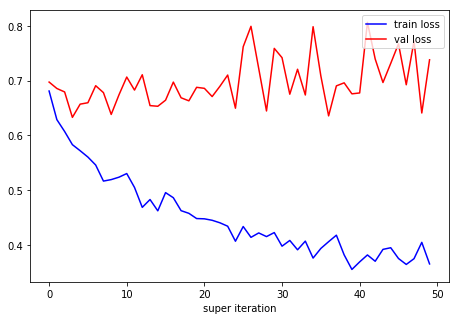

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(7.5,5))
plt.plot(train_loss_history,label='train loss',c='blue')
plt.plot(val_loss_history,label='val loss',c='red')
plt.xlabel("super iteration")
plt.legend(loc='upper right')
plt.savefig("FIGS_siam/" + run + "_loss")

plt.show()

In [20]:
def get_embedding(model, enc_mots):
    model.eval()
    to_embed = torch.tensor(np.array((enc_mots))).to(device)
    embedding = model.forward_once(to_embed)
    return embedding.cpu().detach().numpy()

In [21]:
embedded = get_embedding(model,all_oneHot_motifs)   #range(len(motifs)))

In [22]:
# train_motifs_ = np.genfromtxt('data__for_nerds/train_motifs.csv',dtype='U')
# train_motifxFamMatrix_ = np.genfromtxt('data__for_nerds/train_motifxFamMatrix.csv',delimiter=',',dtype=int)
# test_motifs_ = np.genfromtxt('data__for_nerds/new_test_motifs.csv',dtype='U')
# test_motifxFamMatrix_ = np.genfromtxt('data__for_nerds/new_test_motifxFamMatrix.csv',delimiter=',',dtype=int)

# fams_ = np.genfromtxt('data__for_nerds/fams.csv',dtype='U')

# all_motifs_ = np.hstack([train_motifs_,test_motifs_])
# all_motifxFamMatrix_ = np.vstack([train_motifxFamMatrix_,test_motifxFamMatrix_])

# train_oneHot_motifs_ = get_oneHot_motifs(train_motifs_)
# test_oneHot_motifs_ = get_oneHot_motifs(test_motifs_)
# all_oneHot_motifs_ = np.vstack([train_oneHot_motifs_,test_oneHot_motifs_])

# embedded = get_embedding(model,all_oneHot_motifs_)

In [23]:
df = pd.DataFrame(embedded,dtype=float)
df.to_csv("emb_%s_embedding.csv" % (run),header=None,index=None)

In [24]:
import umap.umap_ as umap
umapper = umap.UMAP(
    n_neighbors=200, # changed from 200
    min_dist=0.1, # changed from 0.1
    n_components=2,
    metric='euclidean' )

s = time.time()
pos_umap = umapper.fit_transform(embedded)
# allDone()

print ("secs: %5.3f" % (time.time()-s))

/usr/local/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../usr/local/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/usr/local/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../usr/local/anaconda3/lib/python3.7/site-package

secs: 101.522


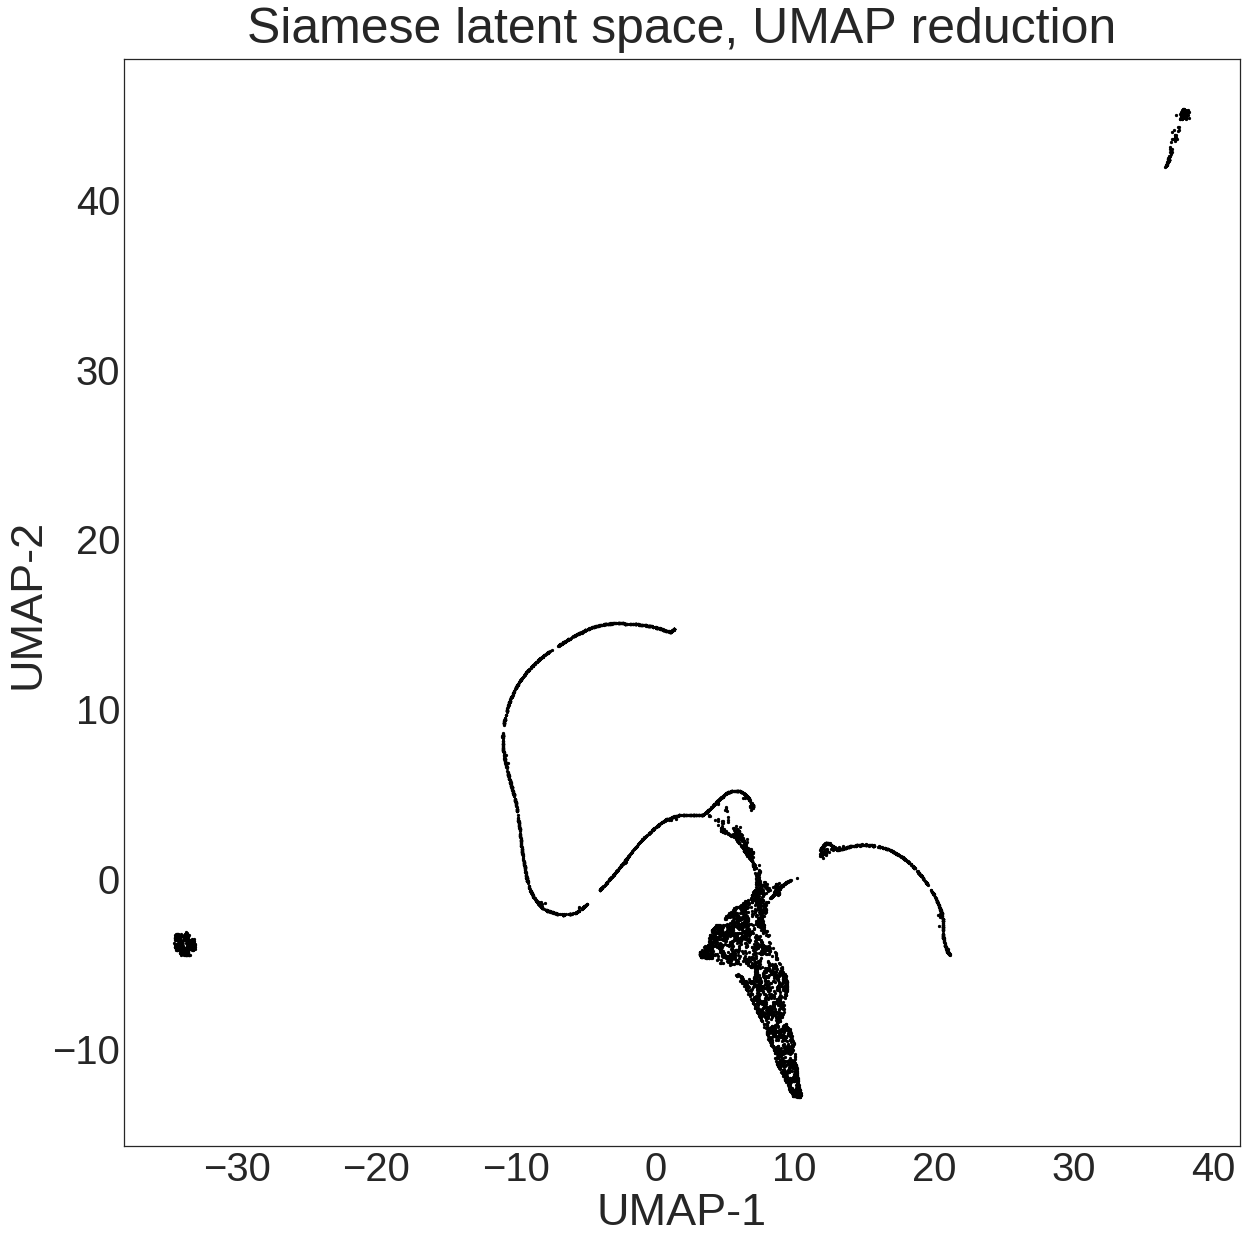

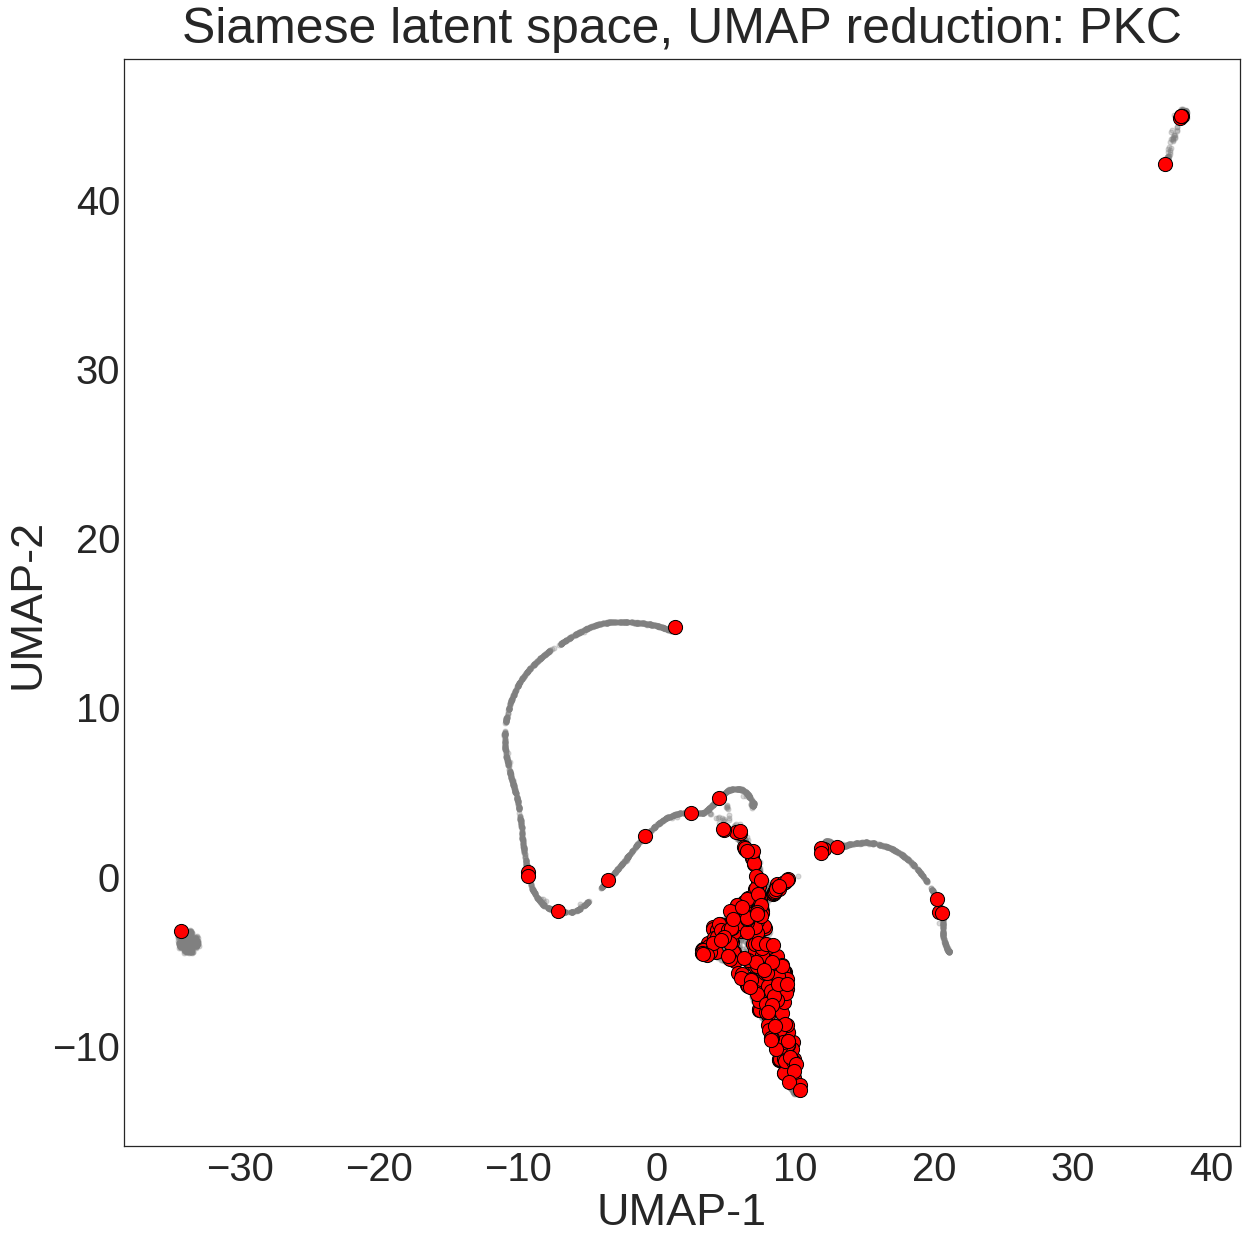

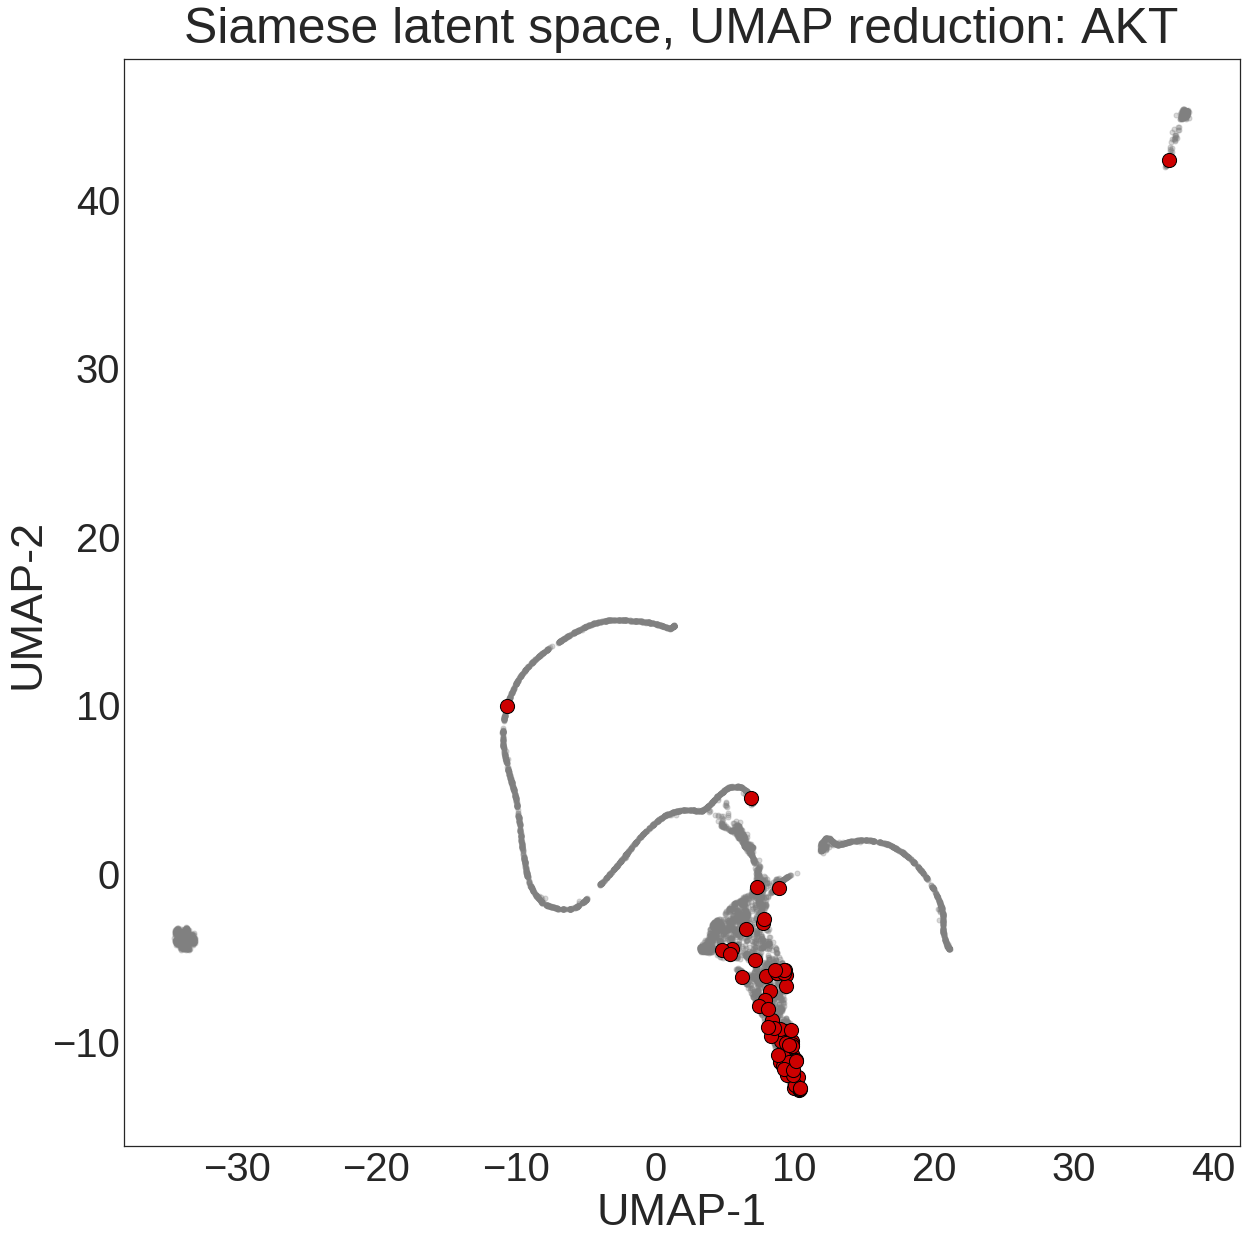

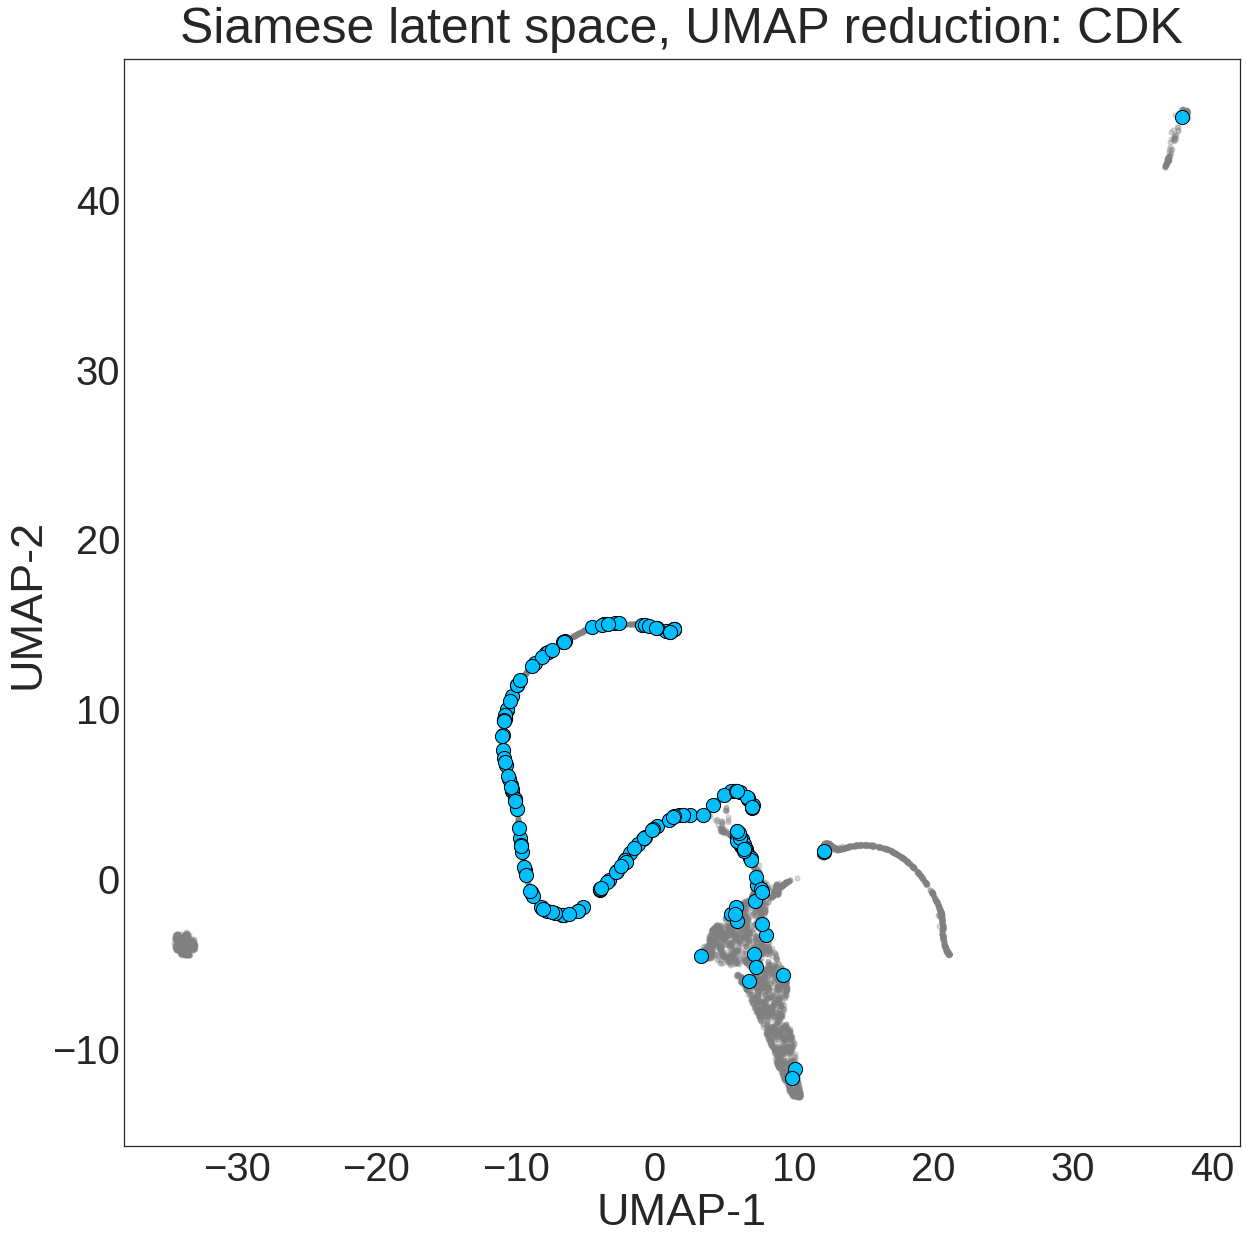

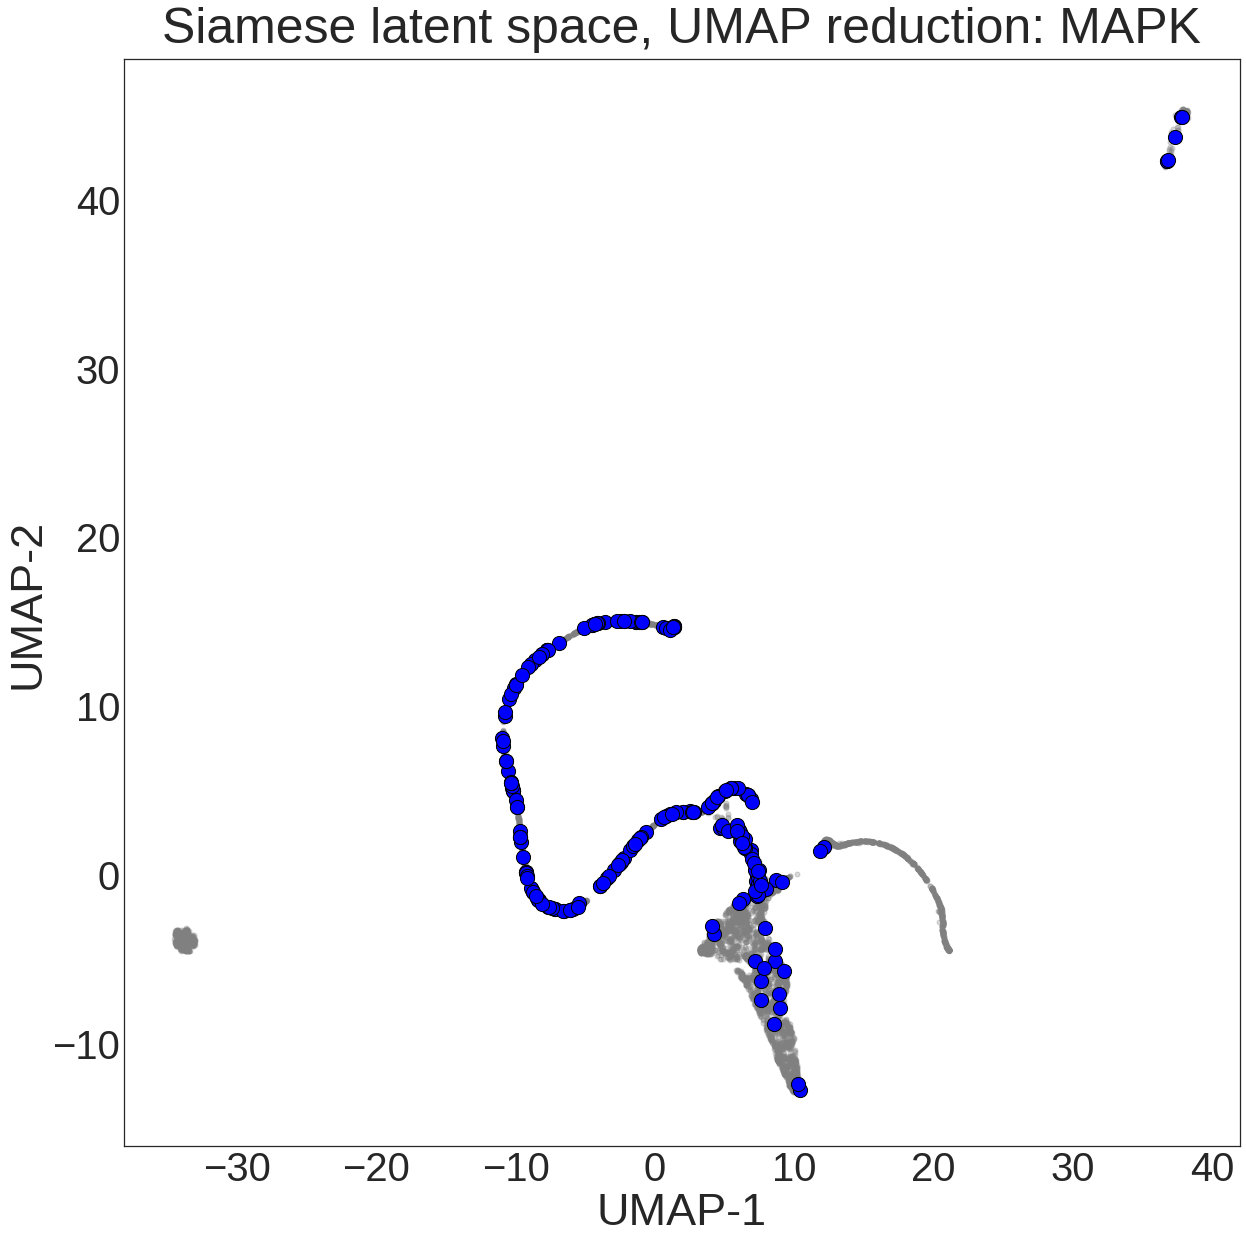

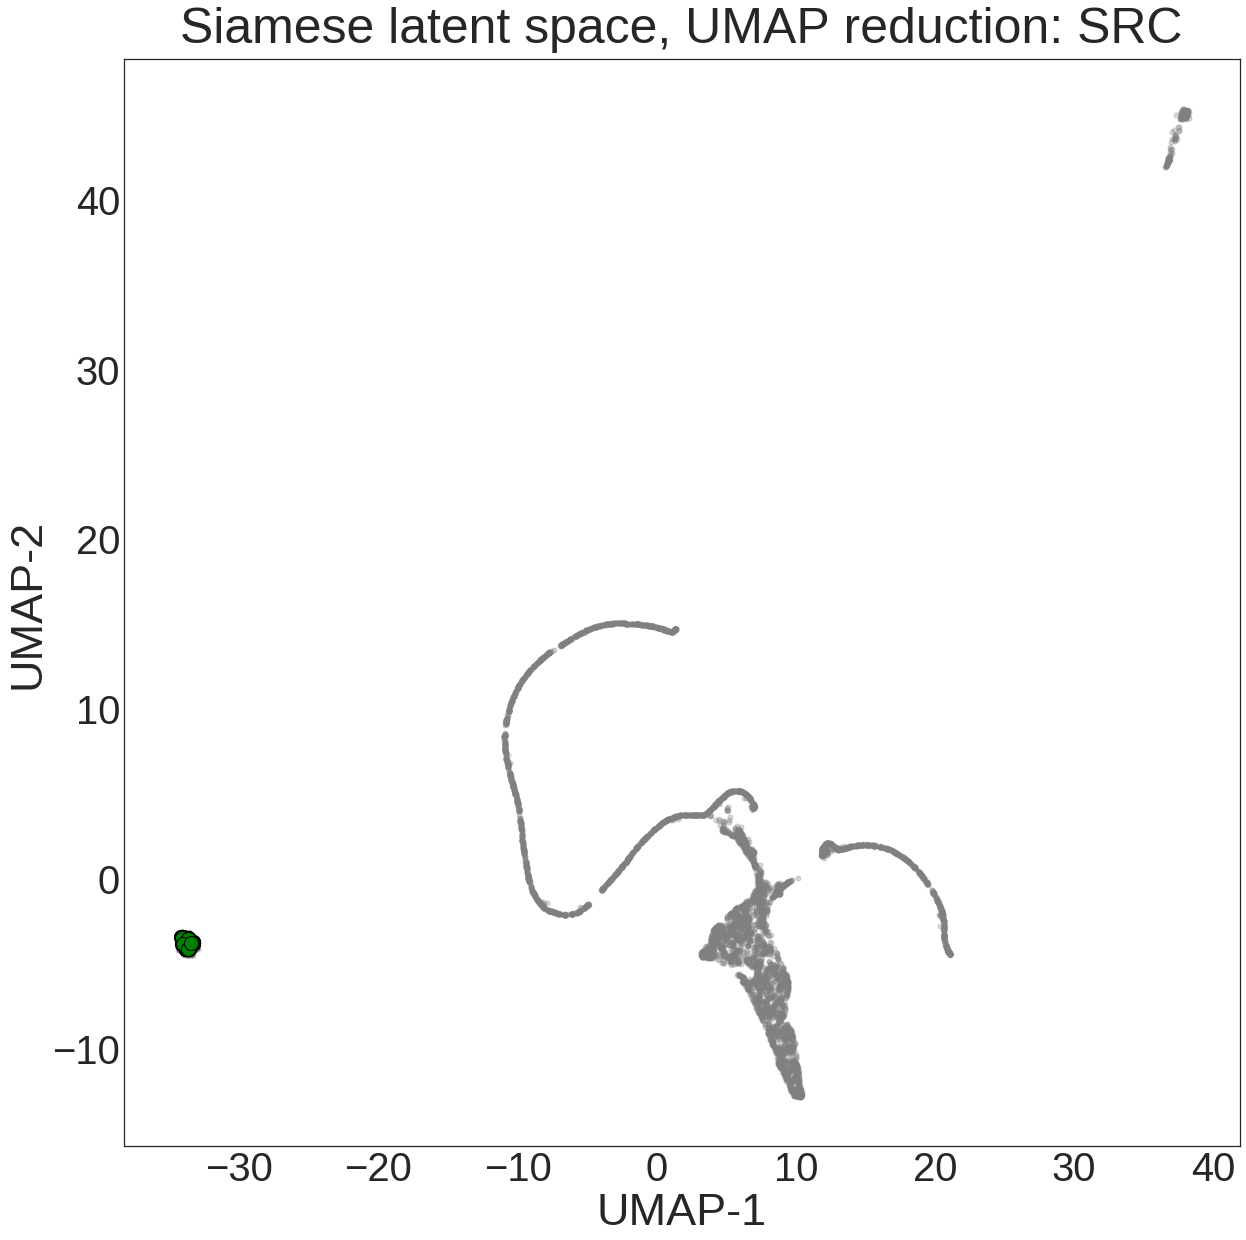

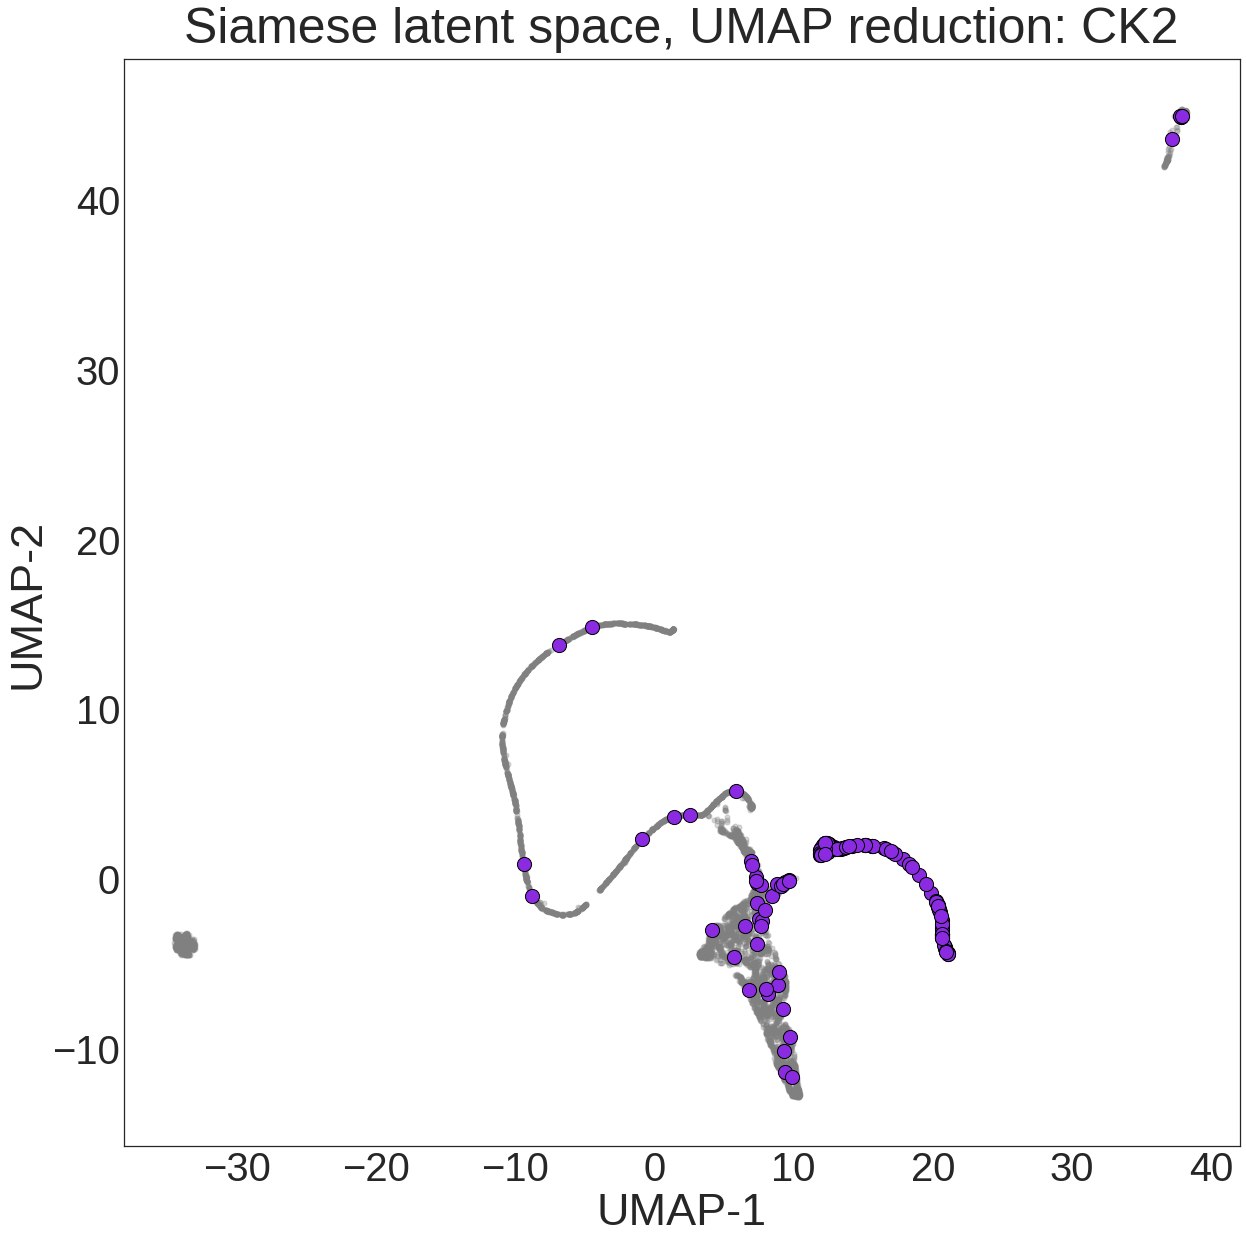

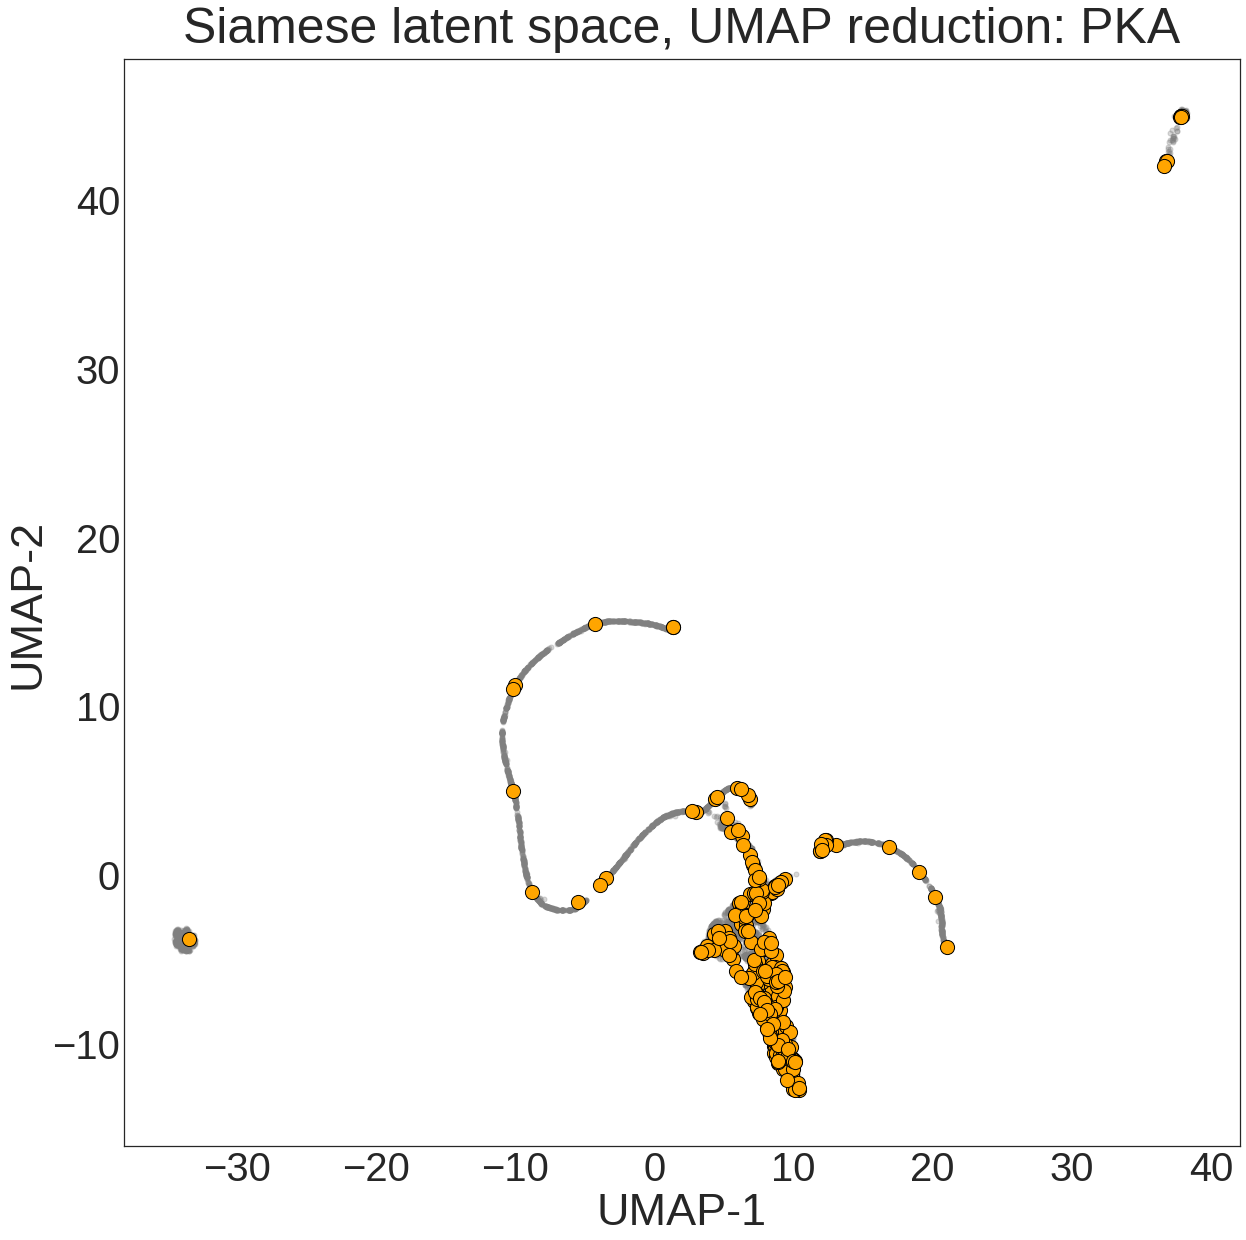

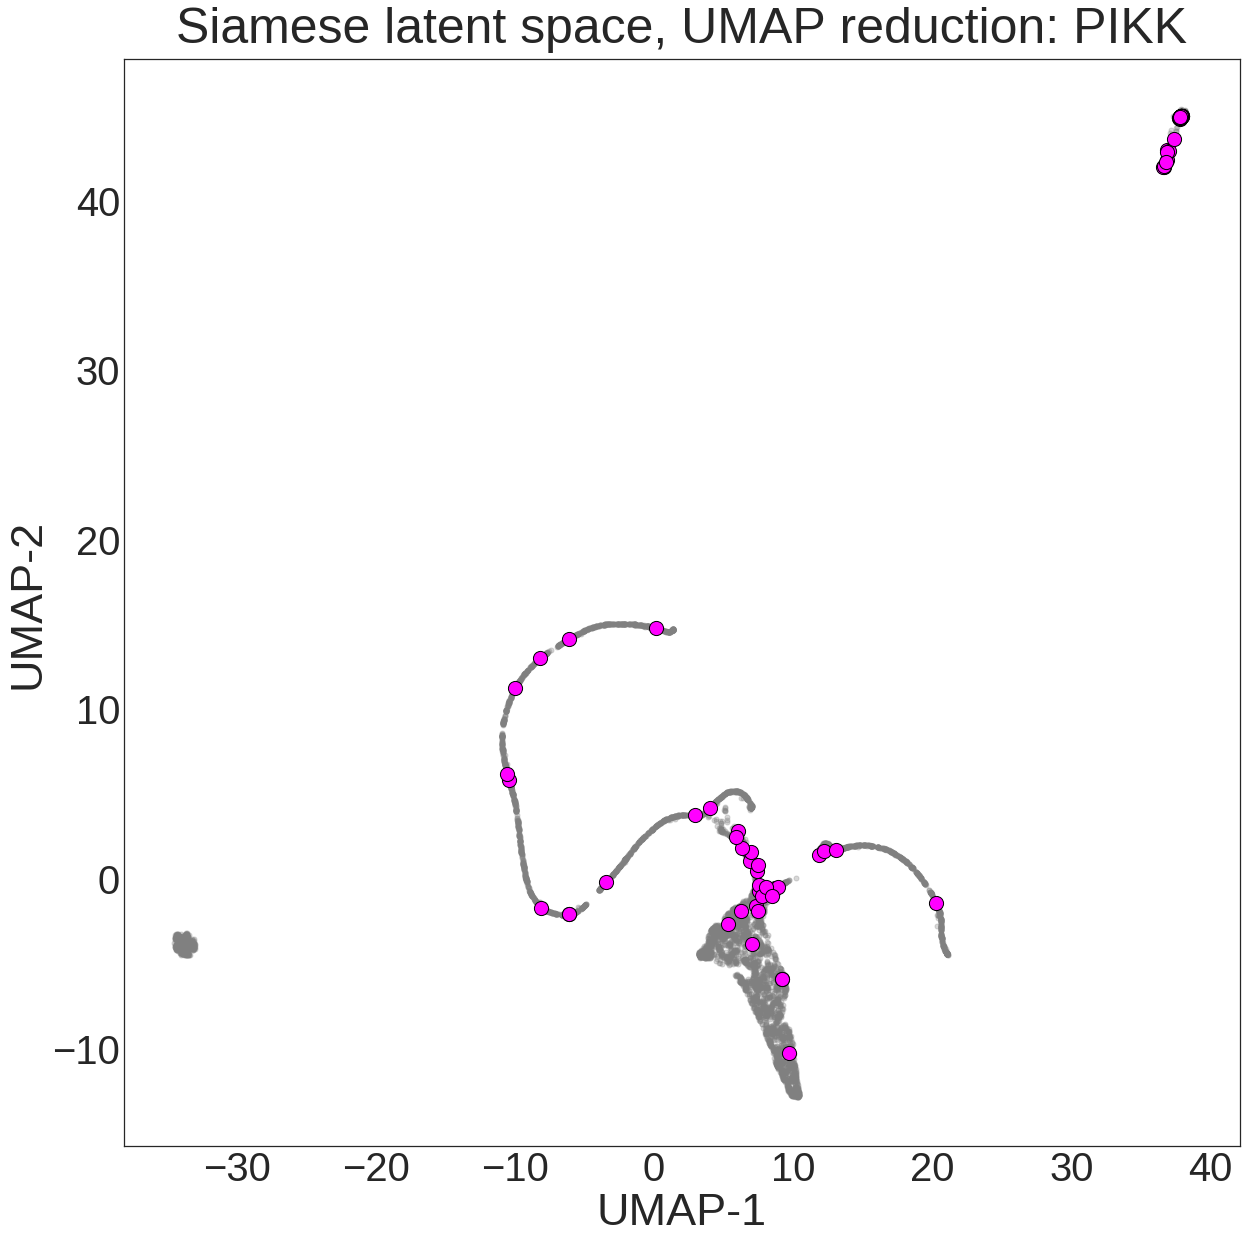

In [25]:
import os
f = 'FIGS_siam/' + run + "/"
os.mkdir(f)

label_size = 45
title_size = 50
tick_size = 40

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

colors = ['red','#CD0000','deepskyblue','blue','green','blueviolet','orange','magenta','blueviolet','violet','deeppink','crimson','mediumslateblue','brown']

plt.figure(figsize=(20,20))
plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black', alpha=1) #alpha=0.25)
plt.title("Siamese latent space, UMAP reduction",fontsize=title_size,y=1.01)
plt.xlabel("UMAP-1",fontsize=label_size)
plt.ylabel("UMAP-2",fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig( f + "noHighlights")
plt.show()

pop_fams = ['PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']
# pop_fams = ['CAMK-UNIQUE', 'DYRK', 'CAMKL', 'STE20', 'PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']


i = -1
for _,fam in enumerate(pop_fams):
    
    i+=1
    fIdx = np.where(fams==fam)[0][0] # fams * * * *
    plt.figure(figsize=(20,20))
    plt.title(("Siamese latent space, UMAP reduction: %s" % fam),fontsize=title_size,y=1.01)
    plt.xticks(fontsize=tick_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    plt.yticks(fontsize=tick_size)
    plt.xlabel("UMAP-1",fontsize=label_size)
    plt.ylabel("UMAP-2",fontsize=label_size)
    plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=25,color='grey',alpha=0.30)
    for mIdx, (x, y) in enumerate(zip(pos_umap[:, 0], pos_umap[:, 1])):
        if all_motifs[mIdx] not in test_motifs: # all_motifs , test_motifs * * * *
            continue
        elif all_motifxFamMatrix[mIdx][fIdx]==1: # all_motifxFamMatrix * * * *
            plt.scatter(x,y,marker='o',s=200,c=colors[i],alpha=1.0,edgecolors='black')          
    plt.savefig((f+"%s" % fam))
    plt.show()